<a href="https://colab.research.google.com/github/rishuatgithub/MLPy/blob/master/Topic_Modelling_LDA_using_ScikitLearn%2BSpacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling using Latent-Dirichlet Allocation

- Blog URL : [Topic Modelling : Latent Dirichlet Allocation, an introduction](https://anotherreeshu.wordpress.com)
- Author   : Rishu Shrivastava

In [1]:
## additional installations in colab
!pip install pyLDAvis
!python -m spacy download en_core_web_lg  ## restart once download is complete.

## general imports

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from spacy import displacy

import pyLDAvis
from pyLDAvis import sklearn
pyLDAvis.enable_notebook()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1: Load and Analyze data

As part of this step we will try to load and analyze our data in order to get a general intuition of our data.

> Source of this dataset is from [BBC News Insight data](http://mlg.ucd.ie/datasets/bbc.html). 

*About the Data: All rights, including copyright, in the content of the original articles are owned by the BBC.*

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
### Reading the dataset from path

filename = '/content/drive/My Drive/Colab Notebooks/data/bbc/bbc_raw_dict.json'
data = pd.read_json(filename)
data.head()

,category,content,filename
0,entertainment,Musicians to tackle US red tape\n\nMusicians' ...,/Users/rishushrivastava/Documents/AI/Dataset/b...
1,entertainment,"U2's desire to be number one\n\nU2, who have w...",/Users/rishushrivastava/Documents/AI/Dataset/b...
2,entertainment,Rocker Doherty in on-stage fight\n\nRock singe...,/Users/rishushrivastava/Documents/AI/Dataset/b...
3,entertainment,Snicket tops US box office chart\n\nThe film a...,/Users/rishushrivastava/Documents/AI/Dataset/b...
4,entertainment,Ocean's Twelve raids box office\n\nOcean's Twe...,/Users/rishushrivastava/Documents/AI/Dataset/b...


In [4]:
### get the shape of the data

data.shape

(2225, 3)

In [58]:
### Check for any null or na

data['content'].isna().value_counts() # no null records found. hence the data is in good quality

False    2225
Name: content, dtype: int64

In [59]:
### distribution of the dataset

data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

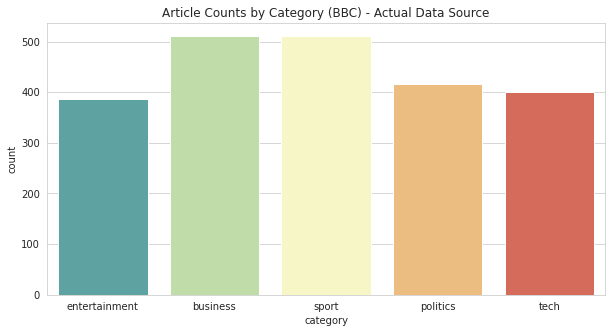

In [5]:
### visualize the category - total article spread.

plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
sns.countplot(x='category',data=data, orient='h', palette='Spectral_r')
plt.title("Article Counts by Category (BBC) - Actual Data Source")
plt.show()

> The BBC news data is currently divided into 5 Major Categories: **Entertainment, Business, Sport, Politics and Tech**.

**Note:** Our target is to understand the BBC news content and build a topic cluster for the news content. We will assume there is no previous knowledge of the above categories. The categories from the original dataset are merely for the purpose of cross-validation and testing.

## Step 2: Data Cleaning and Transformation

> In this step, we will try to clean and transform the existing dataset into a more managable chunks to be able to fit into the LDA model. During this process, we will also try to get a little in-depth intuition of the dataset using NLP techniques.

In [0]:
# load spacy
nlp = spacy.load('en_core_web_lg')

In [30]:
# selecting and analysing the first item in the dataframe
doc_one = nlp(data['content'].iloc[0])

displacy.render(nlp(sample_data_one),style='ent',jupyter=True)


> With the above display, we can notice the varied entities across the dataset.We would like to remove most of the entites out like **PERSON, ORG, CARDINAL, GPE, LOC** and **others**. This will help us in narrowing down the topic words.

In [45]:
## Lets try to reduce down the data set into selected POS.

def parse_filter_document(doc):
  '''
    1. Remove Stop Words 
    2. filter selective POS. 
    3. apply lemma on the tokens
    @returns: list of filtered string
  '''
  filtered_doc = []
  for token in doc:
    if token.is_stop == False | token.is_punct == False | token.is_space == False:
      if token.pos_ in ['NOUN','VERB']:
        filtered_doc.append(token.lemma_)

  return ' '.join(filtered_doc)


print(parse_filter_document(doc_one))

musician tackle tape musician group tackle visa regulation blame hinder act chance succeed singer hope perform expect pay Â£680 obtain visa group include call end deal face performer act face expense bureaucracy visit purpose say musician compare counterpart sponsor petition behalf form amount page musician face regulation athlete journalist mistake form risk year ban ability career say world music market mean bureaucracy say situation prevent act maintain momentum develop add stance endorse artist face struggle succeed thank visa requirement see secretary say imagine orchestra member travel visa process market see benchmark success go fight market add spokeswoman say people experience problem work embassy record industry spokesman say entertainer require visa time visa process application importance exchange facilitate add


> With the above method and applying it on one single document / news article, we can see we have cleaned and reduced the news article into meaningful chunk of data. We will use this method in the subsequent parsing of the data set.

Applying the parser method that we created into all of the dataframe and create a list new column named : **parsed_content**

In [49]:
df = data.copy()

df['parsed_content'] = data['content'].apply(lambda x: parse_filter_document(nlp(x)))

df.head(10)

,category,content,filename,parsed_content
0,entertainment,Musicians to tackle US red tape\n\nMusicians' ...,/Users/rishushrivastava/Documents/AI/Dataset/b...,musician tackle tape musician group tackle vis...
1,entertainment,"U2's desire to be number one\n\nU2, who have w...",/Users/rishushrivastava/Documents/AI/Dataset/b...,desire number win hit cling status band world ...
2,entertainment,Rocker Doherty in on-stage fight\n\nRock singe...,/Users/rishushrivastava/Documents/AI/Dataset/b...,rocker stage fight singer involve fight band g...
3,entertainment,Snicket tops US box office chart\n\nThe film a...,/Users/rishushrivastava/Documents/AI/Dataset/b...,top office chart film adaptation novel top box...
4,entertainment,Ocean's Twelve raids box office\n\nOcean's Twe...,/Users/rishushrivastava/Documents/AI/Dataset/b...,raid box office crime caper sequel star go num...
5,entertainment,'Landmark movies' of 2004 hailed\n\nUS film pr...,/Users/rishushrivastava/Documents/AI/Dataset/b...,movie hail film professional declare passion m...
6,entertainment,Pete Doherty misses bail deadline\n\nSinger Pe...,/Users/rishushrivastava/Documents/AI/Dataset/b...,miss bail deadline singer spend weekend jail c...
7,entertainment,Fockers retain film chart crown\n\nComedy Meet...,/Users/rishushrivastava/Documents/AI/Dataset/b...,focker retain film chart crown hold number spo...
8,entertainment,Top gig award for Scissor Sisters\n\nNew York ...,/Users/rishushrivastava/Documents/AI/Dataset/b...,gig award band win gig year award performance ...
9,entertainment,"Johnny Depp: The acting outlaw\n\nJohnny Depp,...",/Users/rishushrivastava/Documents/AI/Dataset/b...,act outlaw role creator celebrate talent star ...


> Applying TFIDFVectoriser on the new parsed dataframe. This will vectorize the dataframe column : parsed_content. Once the data is vectorized we will fit it into our model.

In [0]:
tfidf_vec = TfidfVectorizer(max_df=0.90, min_df=1, lowercase=True)

In [0]:
df_tfidf = tfidf_vec.fit_transform(df['parsed_content'])

In [53]:
df_tfidf            # a sparse matrix is generated.

<2225x9306 sparse matrix of type '<class 'numpy.float64'>'
	with 183307 stored elements in Compressed Sparse Row format>

> At this step, we are ready to fit our data into the LDA model. We have now cleaned, parsed and vectorised our data. In the next step, we will add the vectorized data into our model.

## Step 3: Defining LDA model

> In this subsequent steps we will try to fit in the LDA model based on the transformed and vectorised dataframe we created in the previous step. Based on our initial data analysis, our target topic cluster will be similar to the one in the original data. This will ensure to generate a clearer understanding of this data.

In [0]:
### Define the LDA model and set the topic size to 5.

topic_clusters = 5            ## assumption is based on the original dataset.

lda_model = LatentDirichletAllocation(n_components=topic_clusters, batch_size=128, random_state=42)

In [61]:
### Fit the filtered data to the model

lda_model.fit(df_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

**Note:** Fitting the model to the dataset may take a long time. You will see the output as model summary, if success.


In [0]:
### Transform the dataset with the generated model

result_df = lda_model.transform(df_tfidf)

> Let us now generate some model outputs based on the dataset. Our model will generate the topics and the word distribution across topics.

In [75]:
### List down the number of generated Topics

# sport ; business  ; politics  ; tech   ; entertainment 

topic_word_dict = {}

print("Topic ID  Word Distribution")
for index, topic in enumerate(lda_model.components_):
  topic_words_max = [tfidf_vec.get_feature_names()[i] for i in topic.argsort()[-15:]]
  topic_word_dict[index] = topic_words_max

  print(f"{index:{8}} {' ,'.join(topic_words_max)}")

Topic ID  Word Distribution
       0 month ,club ,come ,rise ,firm ,sale ,country ,tell ,time ,play ,company ,win ,government ,year ,say
       1 movie ,music ,festival ,comedy ,include ,win ,nomination ,actress ,chart ,band ,album ,actor ,star ,award ,film
       2 school ,manifesto ,minister ,poll ,leader ,asylum ,politic ,campaign ,vote ,tax ,voter ,immigration ,chancellor ,party ,election
       3 cannon ,crab ,gastropod ,weaponry ,joypad ,dinar ,butane ,nicotine ,280bn ,amplify ,slop ,cannibalism ,cannibal ,mask ,panda
       4 site ,video ,use ,player ,computer ,play ,win ,service ,music ,user ,technology ,people ,phone ,say ,game


> From the **above generated topic** and looking at the distribution of words in each of the 5 topics, we can say the following: 

1.   Topic 0 -> relates to Sports
2.   Topic 1 -> relates to Music or Entertainment
3.   Topic 2 -> relates to Politics
4.   Topic 3 -> relates to some sort of Business
5.   Topic 4 -> relates to Technology


Lets try to get more details and generate the weight distribution of topics across the dataframe/documents.

In [78]:
topics = [ "Topic "+str(t) for t in range(lda_model.n_components)]
indexes = [ i for i in range(len(df))]

topic_dist_df = pd.DataFrame(data=np.round(result_df,decimals=2), columns=topics, index=indexes)

dominant_topic = np.argmax(final_result_df.values, axis=1)
topic_dist_df['dominant_topic'] = dominant_topic

topic_dist_df.head(10)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,dominant_topic
0,0.81,0.03,0.11,0.02,0.02,0
1,0.55,0.40,0.02,0.02,0.02,0
2,0.90,0.04,0.02,0.02,0.02,0
3,0.03,0.88,0.03,0.03,0.03,1
4,0.24,0.68,0.03,0.03,0.03,1
5,0.75,0.19,0.02,0.02,0.02,0
6,0.90,0.03,0.03,0.03,0.03,0
7,0.46,0.46,0.03,0.03,0.03,0
8,0.04,0.86,0.03,0.03,0.04,1
9,0.27,0.66,0.02,0.02,0.02,1


## Step 4: Visualizing the LDA Model distribution

> In this step we use a specialised visualisation library called pyLDAvis which aims at generating an interactive visualization for LDA model. 

Read more on pyLDAvis in the [official document](https://pyldavis.readthedocs.io/en/latest/readme.html).

In [0]:
viz = sklearn.prepare(lda_model=lda_model, dtm=df_tfidf, vectorizer=tfidf_vec)

In [81]:
pyLDAvis.display(viz)